In [2]:
from procgen_tools.imports import *

# Visualizing details of the goal misgeneralization nets
Let's understand lots of details about [the goal misgeneralization paper](https://arxiv.org/abs/2105.14111). In particular, we'll be looking at the cheese-maze task from the goal misgeneralization task, for which cheese was spawned in the 5x5 top-right corner of the maze. 

Key conclusions:
1. Convolutional layers limit speed of information propagation (_locality_). More precisely, ignoring the effect of `maxpool2D` layers, any portions of the state separated by `n` pixels take at least `ceil(n/2)` convolutional layers to interact.
2. In the maximal maze size of 64 x 64, there is at most **two** steps of computation involving information from e.g. opposite corners of the maze. 

Let's visualize the network structure. Here's a Mermaid diagram. 

![](https://i.imgur.com/5oSHoVQ.png) 

And here's a more dynamic view; small nodes are activations, and large nodes are `nn.Module`s.

In [3]:
hook.run_with_input(np.zeros((1,3, 64, 64), dtype=np.float32))
hook.get_graph(include_parent_modules=False)

:Graph   [start,end]

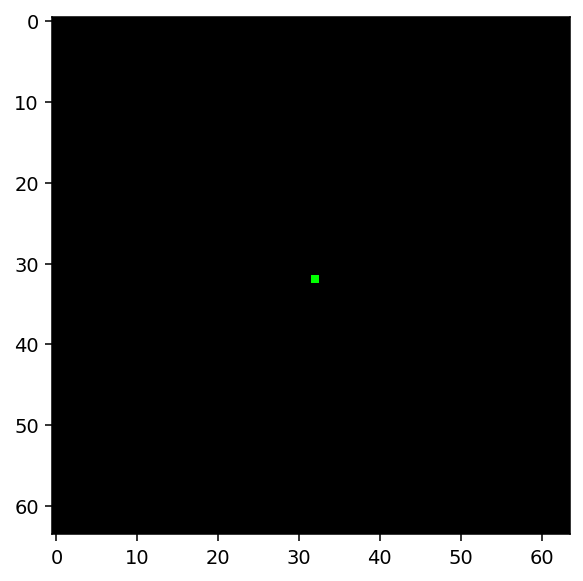

In [4]:
def dummy_obs_pair(color: str, location: Tuple[int, int]=(32,32)):
    """ Returns a mostly-black image pair, the first of which contains a red/green/blue pixel in the center. Returns obs of shape (2, 3, 64, 64). """
    
    assert color in ['R', 'G', 'B'], f'Color must be one of R, G, B, not {color}'
    assert len(location) == 2, 'Location must be a tuple of length 2'
    assert all(0 <= col < 64 for col in location), 'Location must be in [0, 64)'

    channel = {'R': 0, 'G': 1, 'B': 2}[color]
    obs = np.zeros((2, 3, 64, 64), dtype=np.float32)
    obs[0, channel, location[0], location[1]] = 1 # Have one pixel in the middle, in the given channel
    return obs
    
# Let's load a dummy observation with only one nonzero value
plt.imshow(dummy_obs_pair("G")[0].transpose(1,2,0))

In [5]:
# Get the available labels
hook.run_with_input(dummy_obs_pair('R'))
labels = list(hook.values_by_label.keys())[:-1] # Skip the "_out" layer and remove "embedder." prefixes
assert labels == list(map(expand_label, format_labels(labels)))

In [6]:
# Let's visualize the activations at each layer using plotly, using an interactive interface that lets us slide the R/G/B pixel around
def get_activations(label: str, obs: np.ndarray):
    hook.run_with_input(obs) # Run the model with the given obs
    return hook.get_value_by_label(label) # Shape is (b, c, h, w) at conv layers, (b, activations) at linear layers

def activation_diff(label: str, obs: np.ndarray):
    assert obs.shape[0] == 2 # Must be a pair of observations
    
    activations = get_activations(label, obs)
    return activations[0] - activations[1] # Subtract in order to cancel out bias terms which don't behave differently in the presence of the differing inputs 

def plot_activations(activations: np.ndarray, fig: go.FigureWidget):
    """ Plot the activations given a single (non-batched) activation tensor. """
    fig.update(data=[go.Heatmap(z=activations)])

In [7]:
# We can begin to see how information propagates across the net for a dummy single-pixel input
def activ_gen_px(col: int, row: int, label: str, color: str, pair: bool = False):
    """ Get the activations for running a forward pass on a dummy observation, in the given color. Returns shape of (batch, channels, rows, cols), where size batch=1 if pair=False, and batch=2 if pair=True. """
    return get_activations(label, dummy_obs_pair(color, (row, col)))

# Instantiate the plotter
activ_plotter = ActivationsPlotter(labels, plotter=lambda activations, fig: plot_activations(activations[0], fig=fig), activ_gen=activ_gen_px, hook=hook, coords_enabled=True, color="R") # TODO for some reason block2.maxpool_out has a different fig width?
activ_plotter.display()

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': '9f175d6d-0ed6-4549-88e8-672dae288e68',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
              'zmax': 1.0,
              '

In [8]:
# Plot the diff between a single-pixel input and a blank input
activ_plotter = ActivationsPlotter(labels, plotter=lambda activations, fig: plot_activations(activations[0] - activations[1], fig=fig), activ_gen=activ_gen_px, hook=hook, coords_enabled=True, color="R")
activ_plotter.display()

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': 'b6a749a6-a53e-450d-a7b9-65ce6846df81',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
              'zmax': 1.0,
              '

In [9]:
def plot_nonzero_activations(activations: np.ndarray, fig: go.FigureWidget): 
    """ Plot the nonzero activations in a heatmap. """
    # Find nonzero activations and cast to floats
    nz = (activations != 0).astype(np.float32)
    fig.update(data=[go.Heatmap(z=nz)])

def plot_nonzero_diffs(activations: np.ndarray, fig: go.FigureWidget):
    """ Plot the nonzero activation diffs in a heatmap. """
    diffs = activations[0] - activations[1]
    plot_nonzero_activations(diffs, fig)

# Instantiate the plotter
nonzero_plotter = ActivationsPlotter(labels, plotter=plot_nonzero_diffs, activ_gen=activ_gen_px, hook=hook, coords_enabled=True, color="R", pair=True)
nonzero_plotter.display()

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': '41ff8283-89bc-4180-accf-7eeee0d895cc',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
              'zmax': 1.0,
              '

# 1: Locality
Consider `n` convolutional layers (3x3 kernel, stride=1, padding=1) which each preserve the height col width of the previous feature maps. The above demonstrates that after these layers, information can only propagate `n` L1 pixels. The network itself is composed of # TODO 

# Visualizing actual observation activations

In [10]:
default_settings = {'channel_slider': 55, 'label_widget': 'block2.res1.resadd_out'}

In [11]:
def activ_gen_cheese(label: str, venv : ProcgenGym3Env = None): # TODO dont use None
    """ Generate an observation with cheese at the given location. Returns a tensor of shape (1, 3, rows, cols)."""
    assert venv is not None
    cheese_obs = venv.reset() 
    cheese_obs = np.array(cheese_obs, dtype=np.float32)
    activations = get_activations(label, cheese_obs)
    return activations

# Show a maze editor side-by-side with the interactive plotter
SEED = 0
venv = create_venv(num=1, start_level=SEED, num_levels=1) # This has to be a single maze, otherwise the vfield wont work
custom_maze_plotter = ActivationsPlotter(labels, lambda activations, fig: plot_activations(activations[0], fig=fig), activ_gen_cheese, hook, defaults=default_settings, venv=venv)
# Set the default settings


widget_box = custom_vfield(policy, venv=venv, callback=custom_maze_plotter.update_plotter) 
display(widget_box)
    
custom_maze_plotter.display() 
# TODO make it so that it's easy to attach notes to files, load  

Box(children=(HBox(children=(GridspecLayout(children=(Button(layout=Layout(grid_area='widget001', height='0px'…

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': 'f2da7c77-64c8-40e8-b621-5d2a02ca3342',
              'z': array([[ 0.02657299, -0.02839125, -0.07341541, ..., -0.04391609, -0.0239433 ,
                           -0.01430185],
                          [-0.00080868, -0.16516905, -0.19377661, ..., -0.17952022, -0.13850096,
                           -0.08350438],
                          [-0.06065884, -0.24889266, -0.23197651, ..., -0.21075162, -0.19989595,
                           -0.19339341],
                  